In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, mean_absolute_percentage_error
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

In [ ]:
# Load dataset
data = pd.read_csv('dataset.csv')
data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
data = data[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [ ]:

# Check for missing 
data.fillna(method='ffill', inplace=True)

<ipython-input-3-b32020a22618>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
# Feature engineering: Adding rolling mean and relative change
data['Rolling Mean'] = data['Close'].rolling(window=5).mean()
data['Relative Change'] = (data['Close'] - data['Open']) / data['Open']
data.dropna(inplace=True)  # Drop rows with NaN values from rolling mean

In [ ]:
# Feature scaling: Normalize the numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling Mean', 'Relative Change']])

In [ ]:
# Create a new DataFrame with scaled values
scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling Mean', 'Relative Change'])
scaled_df['Open Time'] = data['Open Time']

In [ ]:
data.head()

,Open Time,Open,High,Low,Close,Volume,Rolling Mean,Relative Change
4,2021-01-01 00:13:20,28982.67,28995.93,28971.80,28975.65,24.124339,28983.842,-0.000242
5,2021-01-01 00:13:20,28975.65,28979.53,28933.16,28937.11,22.396014,28978.932,-0.001330
6,2021-01-01 00:13:20,28937.11,28963.25,28937.10,28943.87,20.480294,28965.724,0.000234
7,2021-01-01 00:13:20,28943.88,28954.48,28930.00,28934.84,20.962343,28954.832,-0.000312
8,2021-01-01 00:13:20,28934.84,28936.15,28889.24,28900.00,52.645478,28938.294,-0.001204


In [ ]:
# features and target variable
X = scaled_df[['Open', 'High', 'Low', 'Volume', 'Rolling Mean', 'Relative Change']]
y = data['Close']

In [ ]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# for storing models and results
models = []
evaluation_results = {}

In [ ]:
# for regression metrics
def calculate_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, rmse, r2, mape

In [ ]:
# classification metrics
def calculate_classification_metrics(y_true, y_pred):
    y_true_class = np.round(y_true)
    y_pred_class = np.round(y_pred)
    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, average='weighted', zero_division=1)
    recall = recall_score(y_true_class, y_pred_class, average='weighted', zero_division=1)
    f1 = f1_score(y_true_class, y_pred_class, average='weighted', zero_division=1)
    return accuracy, precision, recall, f1

In [ ]:
# Models
model_definitions = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Support Vector Regressor', SVR(kernel='rbf')),
    ('XGBoost Regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42))
]

In [ ]:
# Train, Predict, and Evaluate
for name, model in model_definitions:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models.append((name, model))
    mae, rmse, r2, mape = calculate_regression_metrics(y_test, y_pred)
    accuracy, precision, recall, f1 = calculate_classification_metrics(y_test, y_pred)
    evaluation_results[name] = {
        'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1
    }


In [ ]:
# Compare models
model_comparison_df = pd.DataFrame(evaluation_results).T
model_comparison_df.sort_values(by='R2', ascending=False, inplace=True)

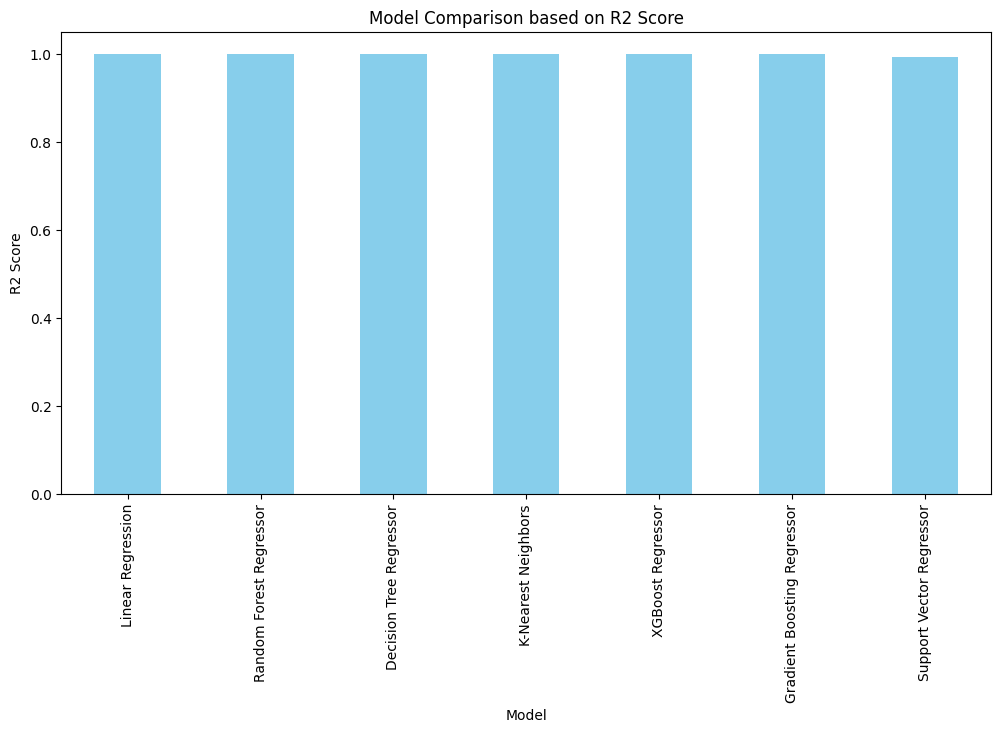

In [ ]:

# Plot model comparison (R2 Score)
plt.figure(figsize=(12, 6))
model_comparison_df['R2'].plot(kind='bar', color='skyblue')
plt.title('Model Comparison based on R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.show()

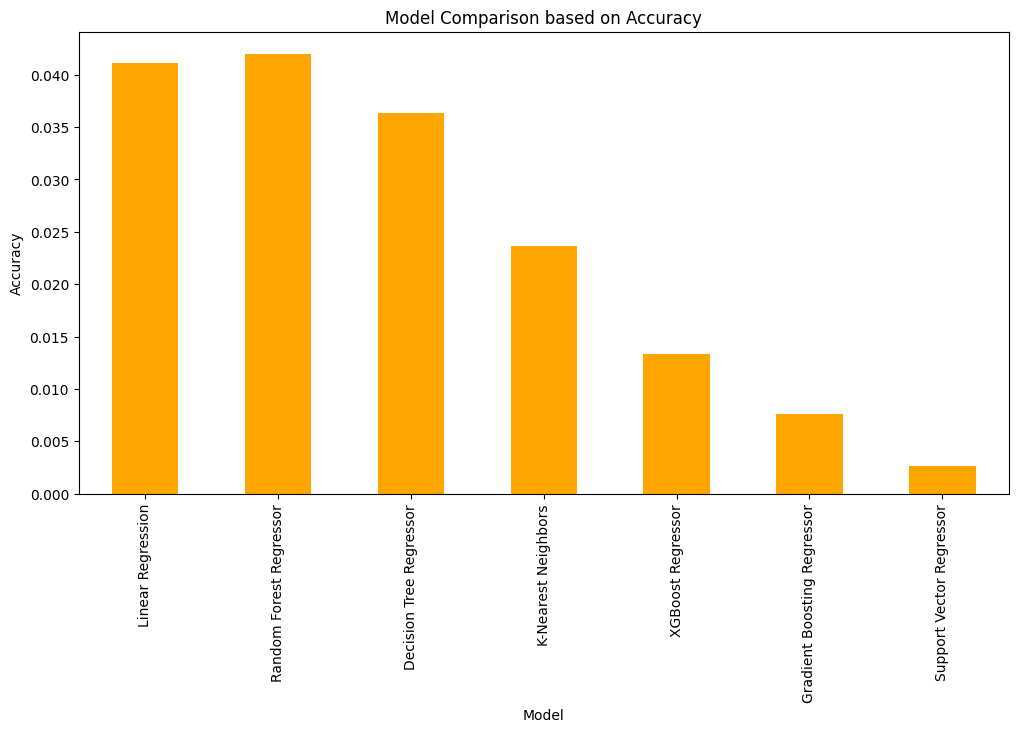

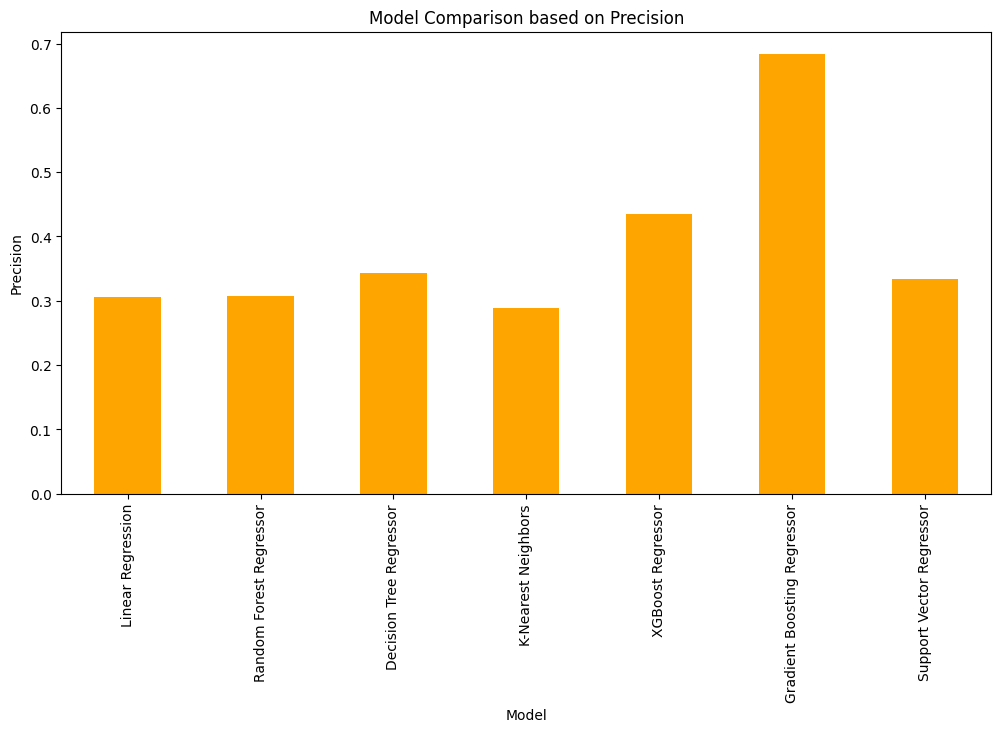

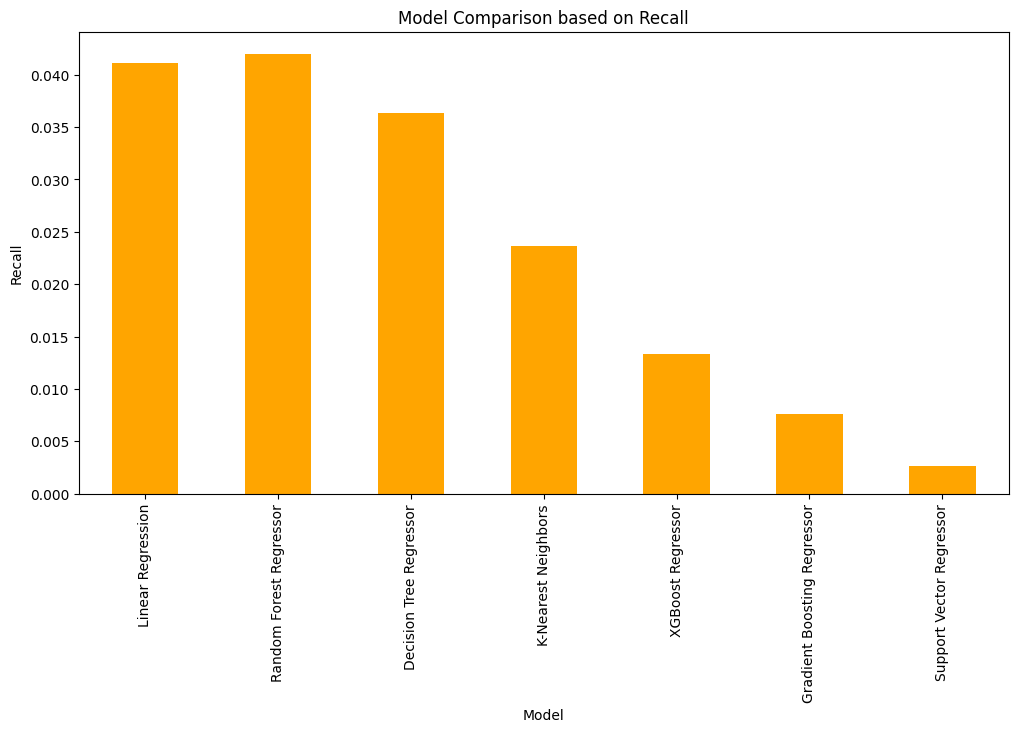

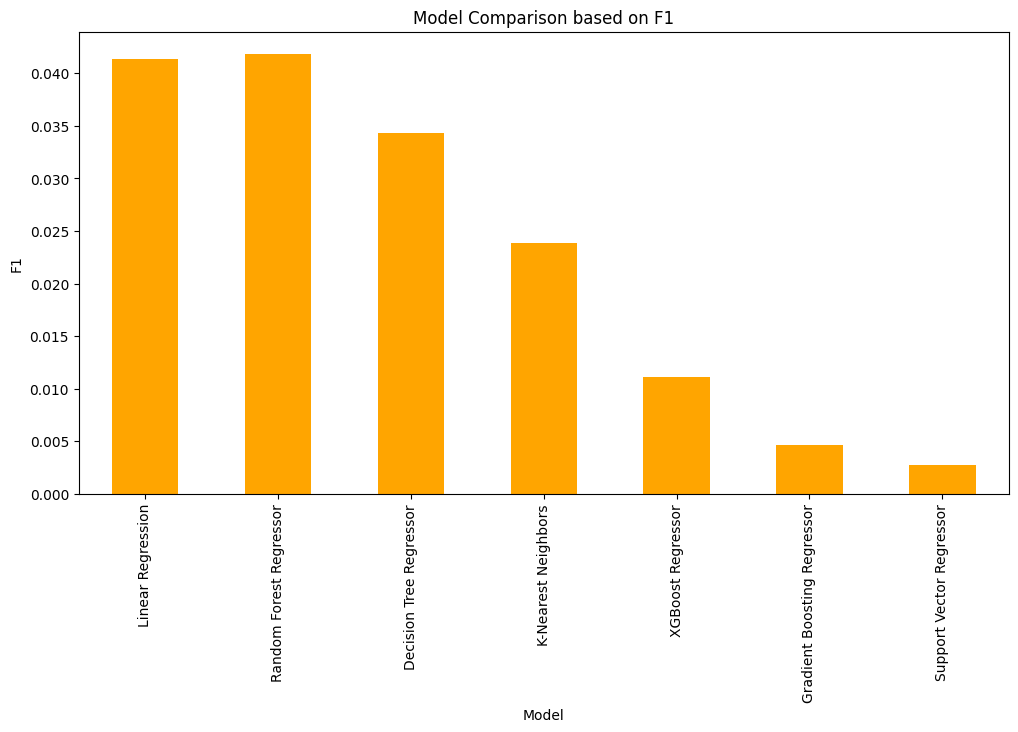

In [ ]:
# Plot model comparison for classification metrics
classification_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric in classification_metrics:
    plt.figure(figsize=(12, 6))
    model_comparison_df[metric].plot(kind='bar', color='orange')
    plt.title(f'Model Comparison based on {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.show()

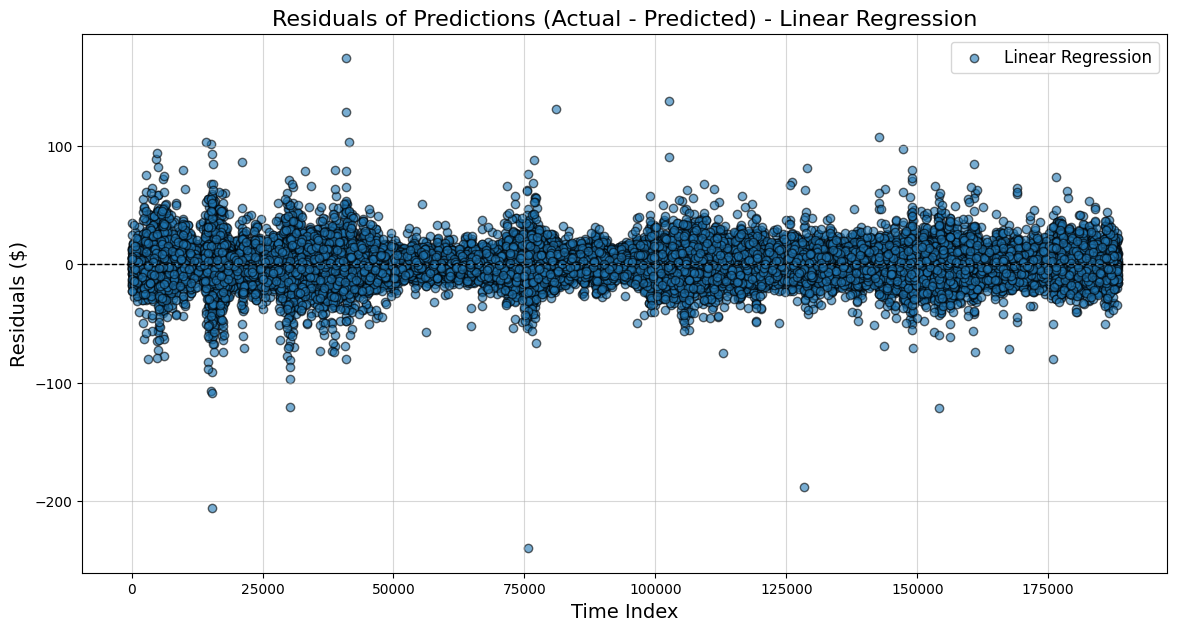

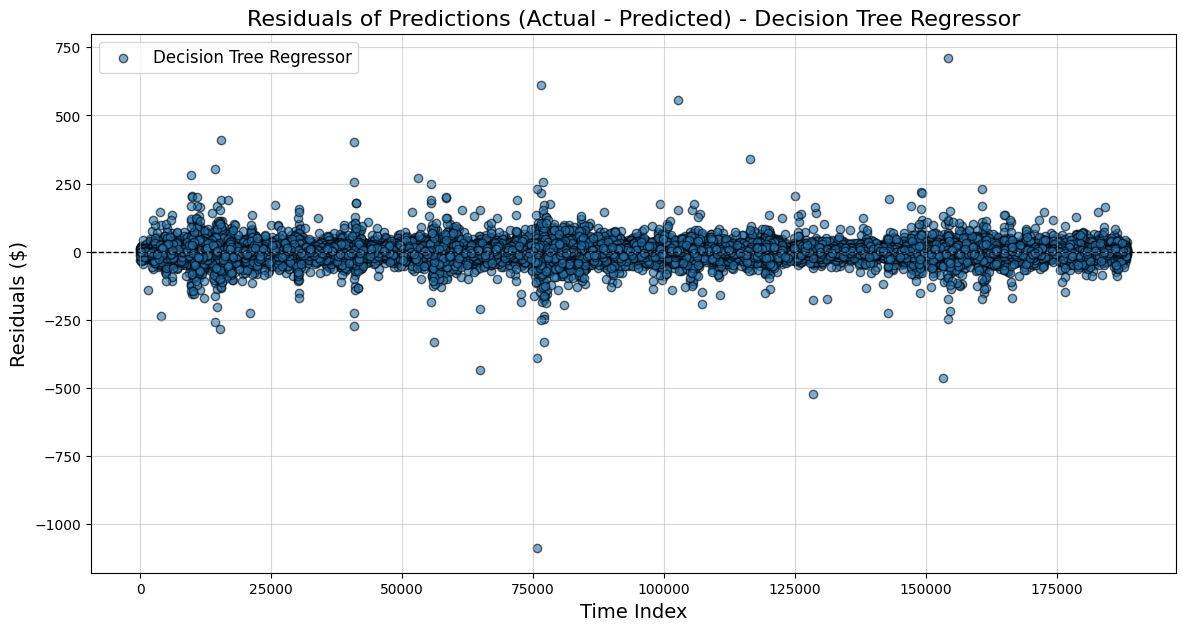

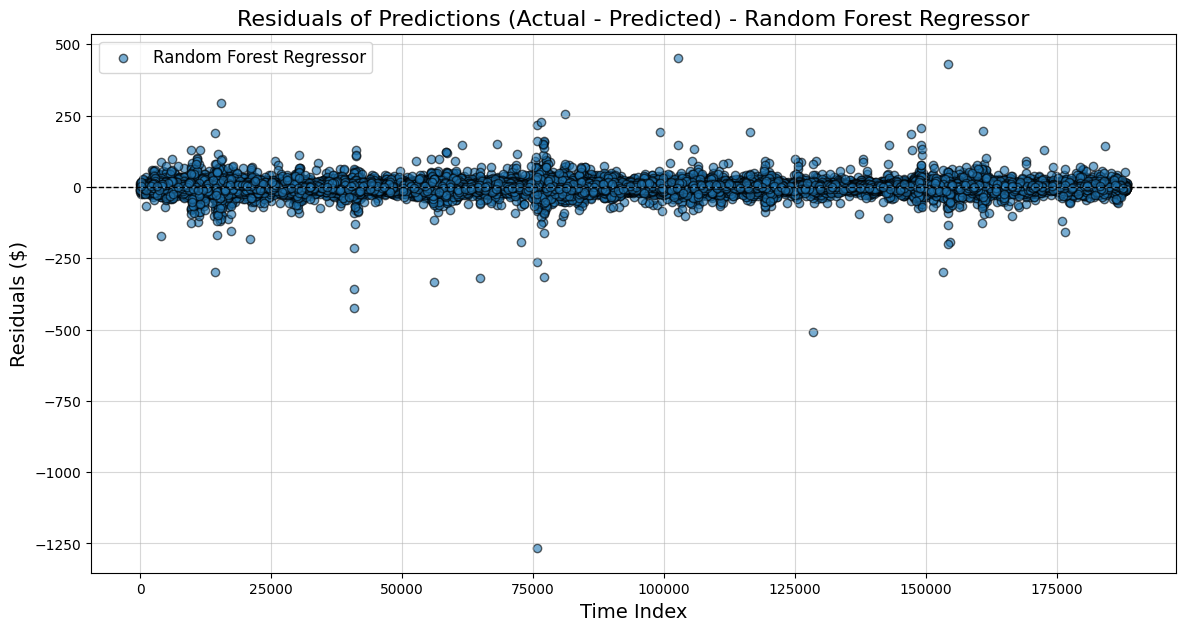

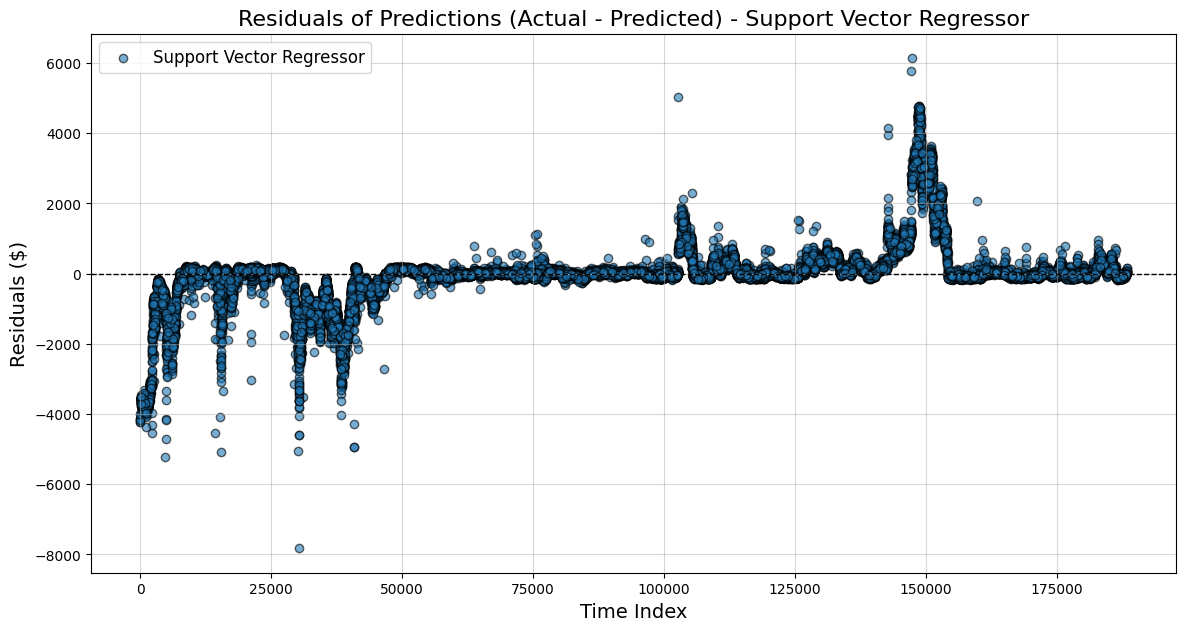

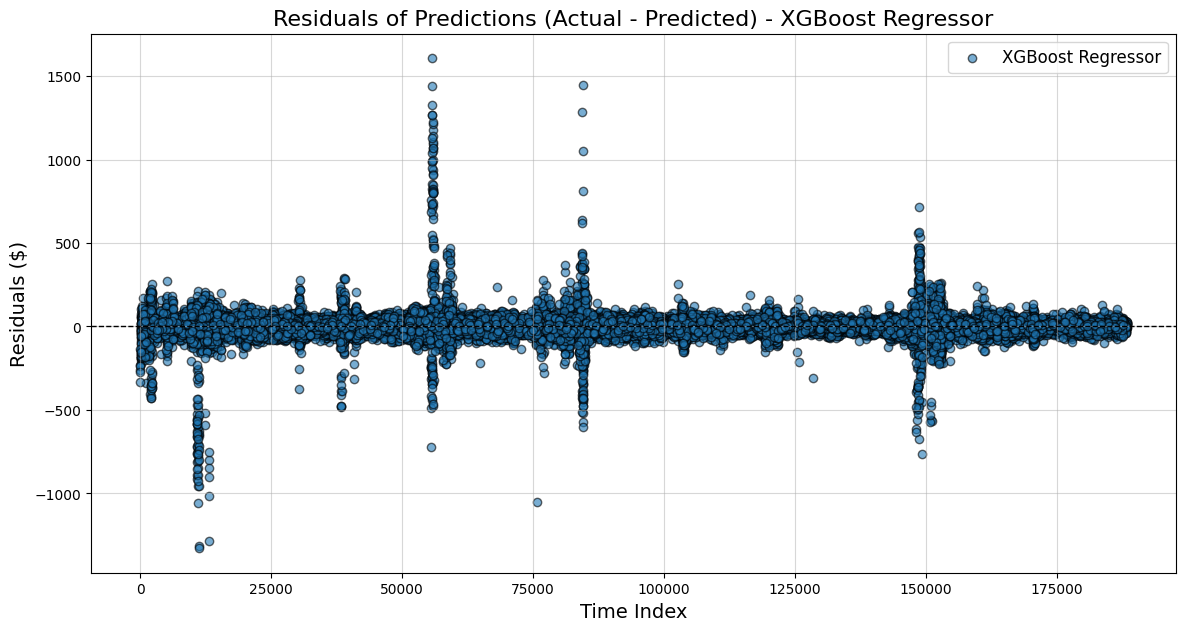

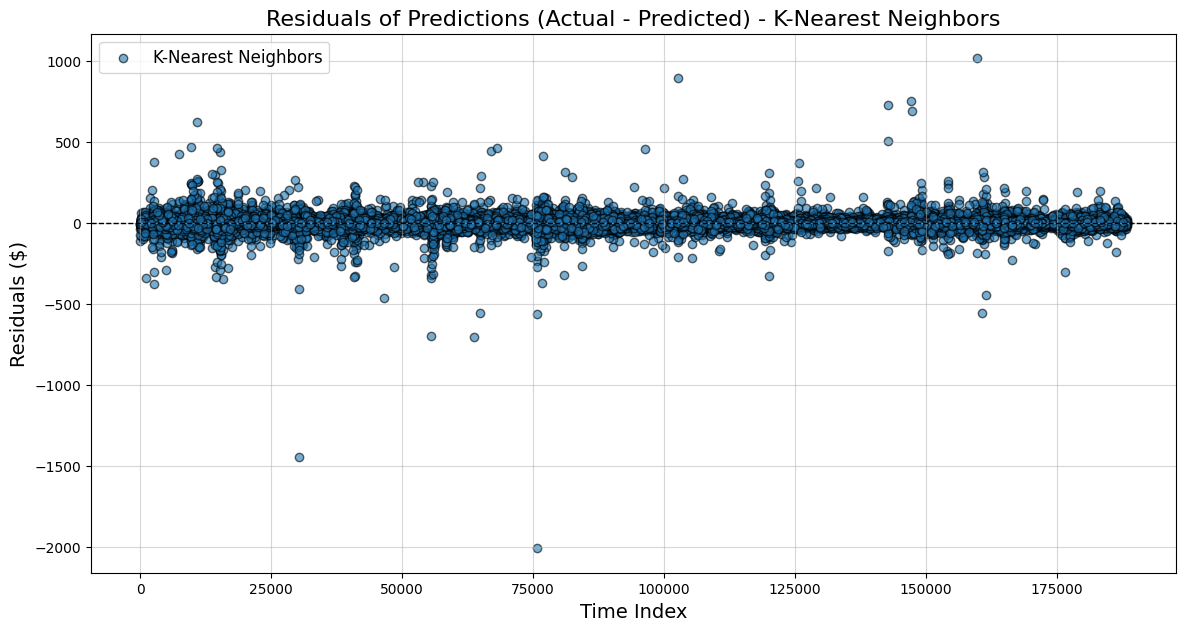

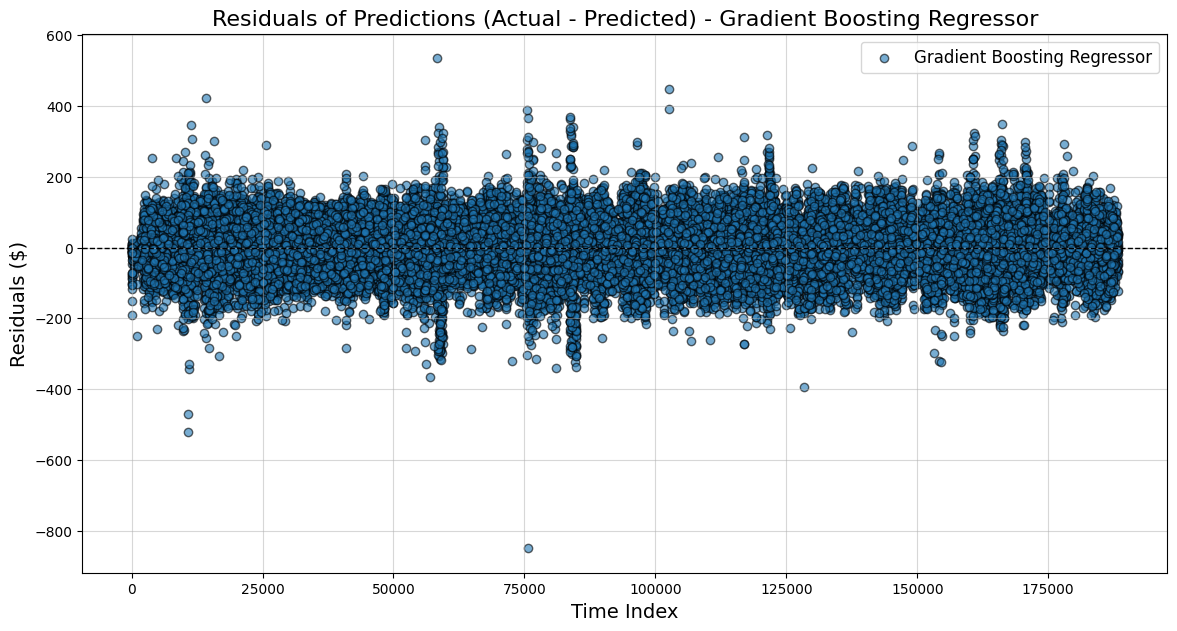

In [ ]:
# Residual Plot for all models
for name, model in models:
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.figure(figsize=(14, 7))
    plt.scatter(y_test.index, residuals, alpha=0.6, edgecolor='k', label=name)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title(f'Residuals of Predictions (Actual - Predicted) - {name}', fontsize=16)
    plt.xlabel('Time Index', fontsize=14)
    plt.ylabel('Residuals ($)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()


In [ ]:
# Save evaluation results to a CSV file
model_comparison_df.to_csv('model_comparison_results.csv', index=True)
print("\nModel evaluation results have been saved to 'model_comparison_results.csv'")


Model evaluation results have been saved to 'model_comparison_results.csv'


In [ ]:
model_comparison = pd.read_csv('model_comparison_results.csv')

In [ ]:
model_comparison.head(10)

,Unnamed: 0,MAE,RMSE,R2,MAPE,Accuracy,Precision,Recall,F1
0,Linear Regression,8.972223,12.894285,0.999998,0.000198,0.041101,0.305936,0.041101,0.041392
1,Random Forest Regressor,9.886270,18.055716,0.999997,0.000217,0.042004,0.307652,0.042004,0.041865
2,Decision Tree Regressor,14.213698,25.177373,0.999993,0.000311,0.036375,0.343773,0.036375,0.034276
3,K-Nearest Neighbors,18.569653,35.503482,0.999987,0.000415,0.023657,0.288204,0.023657,0.023853
4,XGBoost Regressor,32.512277,69.015468,0.999951,0.000722,0.013329,0.434213,0.013329,0.011084
5,Gradient Boosting Regressor,52.782174,70.959677,0.999948,0.001132,0.007567,0.684120,0.007567,0.004630
6,Support Vector Regressor,385.611947,823.805719,0.993020,0.009282,0.002655,0.334541,0.002655,0.002724


from matplotlib import pyplot as plt
_df_0['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['MAPE'].plot(kind='hist', bins=20, title='MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Unnamed: 0').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='R2', y='MAPE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='MAPE', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Unnamed: 0')):
  _plot_series(series, series_name, i)
  fig.legend(title='Unnamed: 0', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Unnamed: 0')):
  _plot_series(series, series_name, i)
  fig.legend(title='Unnamed: 0', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Unnamed: 0')):
  _plot_series(series, series_name, i)
  fig.legend(title='Unnamed: 0', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Unnamed: 0')):
  _plot_series(series, series_name, i)
  fig.legend(title='Unnamed: 0', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
_df_13['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['MAPE'].plot(kind='line', figsize=(8, 4), title='MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Unnamed: 0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='MAE', y='Unnamed: 0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Unnamed: 0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='RMSE', y='Unnamed: 0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Unnamed: 0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='R2', y='Unnamed: 0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Unnamed: 0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='MAPE', y='Unnamed: 0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)